In [50]:
import numpy as np
from math import sqrt
import random 
import itertools
import copy
import matplotlib.pyplot as plt

def initialObstacle(obstacle):
    x = np.random.choice(len(obstacle),10)
    y = np.random.choice(len(obstacle[0]),10)
    for i,j in zip(x,y):
        obstacle[i][j] = 1
    return np.array(obstacle),np.vstack((x,y))

def createSample(tree_list,candidates):
    xrand = list(random.sample(candidates,1)[0])
    tree = np.array(tree_list)[:,:2]
    while xrand in tree:
        xrand =  list(random.sample(candidates,1)[0])
    return xrand

def findNear(tree_list,xrand):
    m = np.inf
    for tree_node in tree_list:
        dis = abs(tree_node[0]-xrand[0])+abs(tree_node[1]-xrand[1])
        if dis <m:
            m = dis
            xnear = [tree_node[0],tree_node[1]]
    return xnear

def decideDirection(xrand,xnear,step):
    z = sqrt((xrand[0]-xnear[0])**2+(xrand[1]-xnear[1])**2)
    cost = -(xnear[0]-xrand[0])/z
    sint = -(xnear[1]-xrand[1])/z
    xnew = copy.deepcopy(xnear)
    xnew[0] += step*cost
    xnew[1] += step*sint
    return xnew

def checkCollision(xnew,xnear,obstacle,step=1):
    x,y = np.where(obstacle==1)
    crash = False

    for i,j in zip(x,y):
        r1 = [xnew[0]-i,xnew[1]-j]
        r2 = [xnear[1]-i,xnear[1]-j]
        r1_r = sqrt(r1[0]**2+r1[1]**2)
        r2_r = sqrt(r2[0]**2+r2[1]**2)
        if r1_r<step or r2_r<step:
            crash = True
            return crash
        cosr = (r1[0]*r2[0]+r1[1]*r2[1])/r1_r/r2_r
        d = r1_r*r2_r*sqrt(1-cosr**2)/step
        if d < step and i>=min(xnew[0],xnear[0]) and i<max(xnew[0],xnear[0]):
            crash = True
            return crash
        
    return crash

def proposeNewNode(tree_list,candidates,step):
    xrand = createSample(tree_list=tree_list,candidates=candidates) # sample from candidates
    xnear = findNear(tree_list,xrand)  # find the nearest node from the tree lists
    xnew = decideDirection(xrand,xnear,step) # propose the new node
    return xnew ,xnear, xrand
def plotCircle(xi,yi,r):
    x = np.linspace(xi-r, xi+r, 100)
    y = np.linspace(yi-r, yi+r, 100)
    X, Y = np.meshgrid(x,y)
    F = (X-xi)**2 + (Y-yi)**2
    plt.contour(X,Y,F,[r])





In [51]:
#main difference from RRT
def random_relink(tree_list,t,xnew,obstacle):
    tree_list = np.array(tree_list)
    xnew_parent_idx = np.where(((tree_list[:,0]==xnew[0])&(tree_list[:,1]==xnew[1])))[0]
    if len(xnew_parent_idx)>1:
        print (tree_list[xnew_parent_idx])
    xnew_distance = tree_list[xnew_parent_idx,-1]
    for i,edge in enumerate(tree_list):
        parent_xnew_distance = sqrt((edge[0]-xnew[0])**2+(edge[1]-xnew[1])**2)
        # print (parent_xnew_distance, xnew_distance, edge[-1])
        if parent_xnew_distance<1.0*t and parent_xnew_distance + xnew_distance <edge[-1] and not checkCollision(xnew,edge[:2],obstacle,t):
            delta_d = parent_xnew_distance + xnew_distance-edge[-1]
            tree_list[i,2] = xnew[0]
            tree_list[i,3] = xnew[1]
            tree_list[i,4] = parent_xnew_distance + xnew_distance
            child_parent_idx = np.where(((tree_list[:,2]==edge[0])&(tree_list[:,3]==edge[1])))[0]
            tree_list[child_parent_idx,-1] = delta_d
    return tree_list.tolist()
def rewrite(tree_list, t, xnew,obstacle):
    candidate_parents_new = []
    for edge in tree_list:
        distance = sqrt((edge[0]-xnew[0])**2+(edge[1]-xnew[1])**2)
        if distance < 1.5*t and (xnew[0]!=edge[0] or xnew[1]!=edge[1]) and not checkCollision(xnew,edge[:2],obstacle,t):
            distance += edge[4]
            candidate_parents_new.append([edge[0],edge[1],distance])
    tree_np = np.array(tree_list)
    xnew_parent_idx = np.where(((tree_np[:,0]==xnew[0])&(tree_np[:,1]==xnew[1])))[0]
    if len(xnew_parent_idx)>0:
        return
    candidate_parents_new = np.array(candidate_parents_new)
    idx_min = np.argmin(candidate_parents_new[:,2],axis=0)
    parent = candidate_parents_new[idx_min]
    tree_list.append([xnew[0],xnew[1],parent[0],parent[1],parent[2]])
    
    return


In [52]:
# intialize the space
x_width = 25
y_width = 25
obstacle = [[0 for j in range(x_width)] for i in range(0,y_width)]
obstacle,blocks = initialObstacle(obstacle)
x0,y0 = 0,0
xn,yn = 15,15
step = 1
obstacle[x0][y0] = 2
obstacle[xn][yn] = 3
candidates = list(itertools.product(range(x_width),range(y_width)))

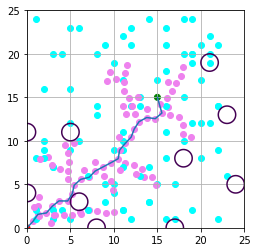

In [58]:
plt.figure()
ax = plt.subplot()
tree_list = []
tree_list.append([x0,y0,x0,y0,0])


# propose the first node sample
xnew,xnear,xrand = proposeNewNode(tree_list,candidates,step=step)
# check whether (xnew,xnear) crashes obstacle
while (checkCollision(xnew,xnear,obstacle)): 
    # previous new node crashes, propose the new node
    xnew,xnear,xrand = proposeNewNode(tree_list,candidates,step=step)

# add the safe node into tree list   
rewrite(tree_list,step,xnew,obstacle)
plt.scatter(xrand[0],xrand[1],c='cyan')
plt.scatter(xnew[0],xnew[1],c='violet')

# check whether the new node reaches the target node; repeat proposing the new node
while((xnew[0]-xn)**2+(xnew[1]-yn)**2>step**2):
    xnew,xnear,xrand = proposeNewNode(tree_list,candidates,step=step)

    while (checkCollision(xnew,xnear,obstacle)):
        xnew,xnear,xrand = proposeNewNode(tree_list,candidates,step=step)
    rewrite(tree_list,step,xnew,obstacle)
    random_relink(tree_list,step,xnew,obstacle)


    plt.scatter(xrand[0],xrand[1],c='cyan')
    plt.scatter(xnew[0],xnew[1],c='violet')
tree_list = np.array(tree_list)

# backward to find out the path from starting point (x0,y0) to target point(xn,yn)
route_list = [[xn,yn]]
xlast = [xnew[0],xnew[1]]
while xlast[0]!=x0 or xlast[1]!=y0:
    idx = np.where(((tree_list[:,0]==xlast[0]) &(tree_list[:,1]==xlast[1])))[0][0]
    xlast = tree_list[idx,2:4]
    route_list.append(list(xlast))
route_list = np.array(route_list)



plt.scatter([x0,xn],[y0,yn],c=['r','g']) # plot the start/target
for xi,yi in zip(blocks[0],blocks[1]): # plot obstacle
    plotCircle(xi,yi,r=1)
plt.xlim(0,x_width)
plt.ylim(0,y_width)
plt.grid()
ax.set_aspect('equal')
plt.plot(route_list[:,0],route_list[:,1]) # plot the path
plt.show()
